In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [10]:
df_train = pd.read_csv("train.csv")
df_train.head()

id       v1       v2       v3  ...     v510     v511     v512  glasses
0   1  0.37797 -0.94808  0.01346  ...  1.08635  1.69027  0.61609        0
1   2  0.07609 -0.09774  0.39666  ...  0.00866 -1.27640 -0.60496        1
2   3  1.19391 -0.68707 -0.68422  ... -0.60177  0.43555  0.41982        1
3   4  1.34949 -0.31498 -1.30248  ...  0.83997 -0.46986  0.06755        0
4   5 -0.03512 -0.34196  0.14230  ...  0.83641  0.59756 -0.20298        0

[5 rows x 514 columns]

In [70]:
df_test = pd.read_csv("test.csv")
df_test = df_test.drop(columns=['id'])
df_test.head()

v1       v2       v3       v4  ...     v509     v510     v511     v512
0  0.48039 -0.32247 -0.44262  0.29790  ...  0.30127 -0.65184 -0.25504  0.51825
1  1.65497 -0.40396 -0.87412 -0.32837  ...  0.58029 -0.44552  0.40221  1.44524
2  0.66835 -0.88843 -1.03717  0.50920  ... -1.68200  1.34367 -0.03853  1.13161
3  0.07134 -1.13284 -1.13902  0.74864  ... -0.17401  0.07702 -0.00753  0.71057
4  0.14553 -0.06097 -0.58112  0.16331  ...  0.20894 -1.08812 -0.90550 -0.38300

[5 rows x 512 columns]

In [12]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [13]:
# Correlation matrix
def plotCorrelationMatrix(df, name, graphWidth):
    filename = name
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [14]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

### Column Distribution

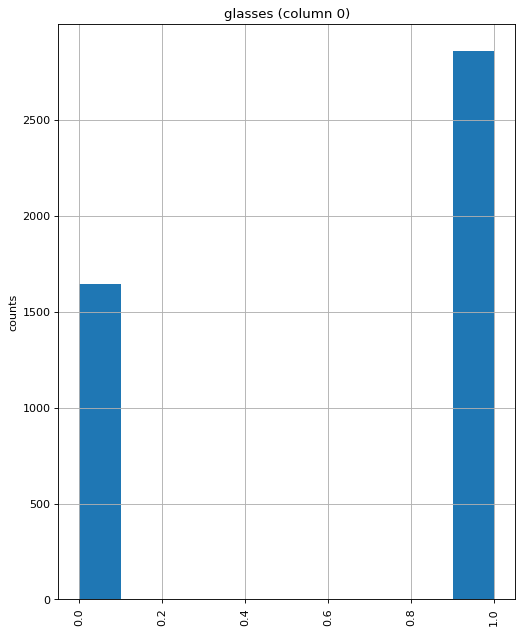

In [15]:
plotPerColumnDistribution(df_train, 10, 5)

### Correlation Matrix for Training Dataset

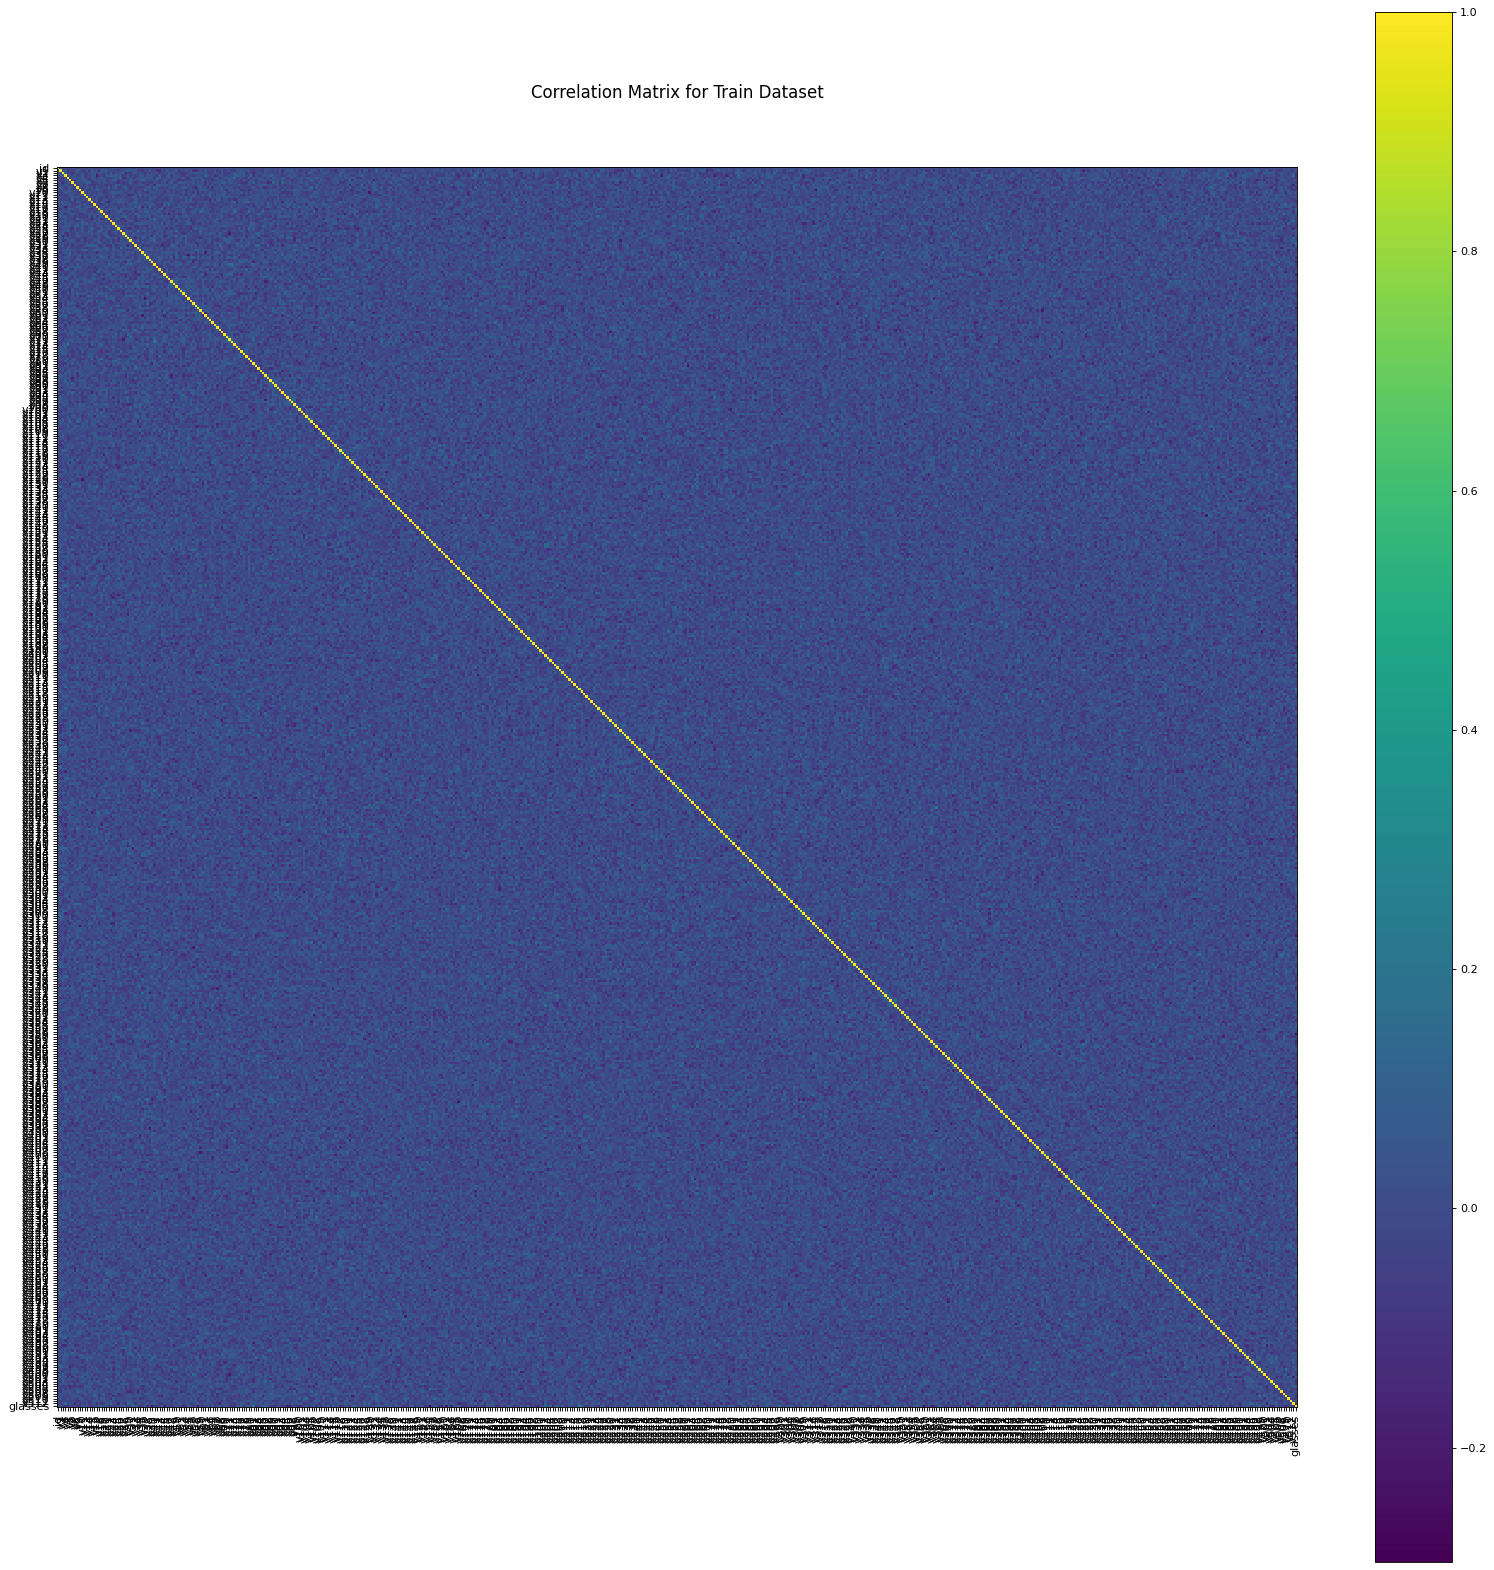

In [16]:
plotCorrelationMatrix(df_train, "Train Dataset", 25)

### Scatter Matrix for Training Dataset

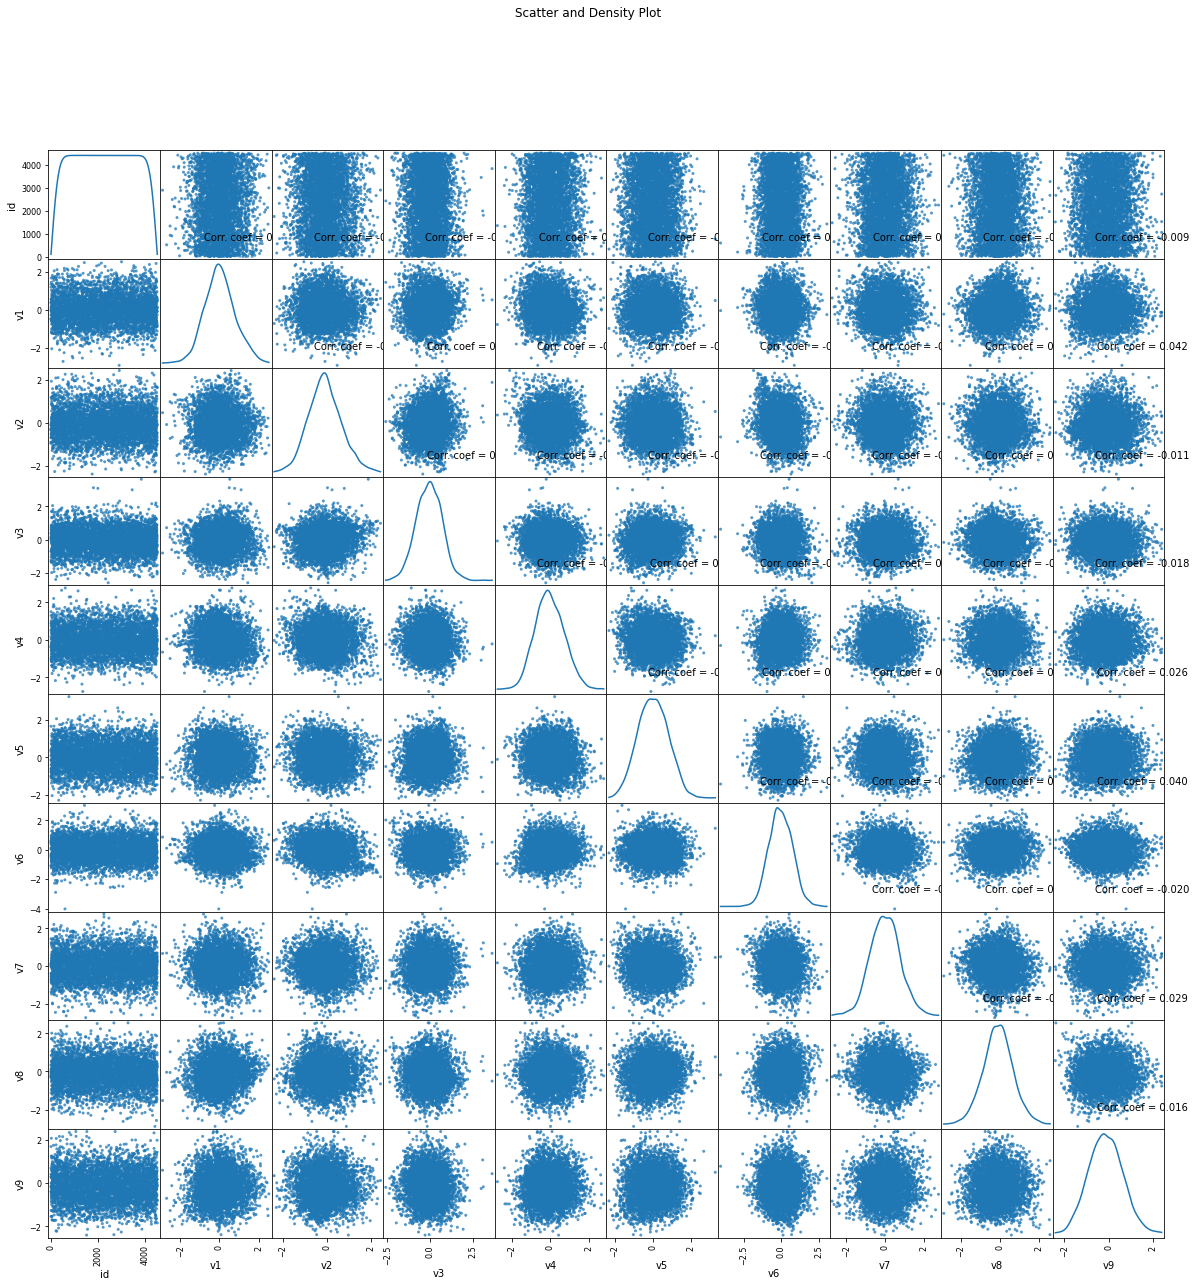

In [17]:
plotScatterMatrix(df_train, 20, 10)

In [18]:
plotPerColumnDistribution(df_test, 10, 5)

<Figure size 2400x512 with 0 Axes>

### Correlation Matrix for Test Dataset

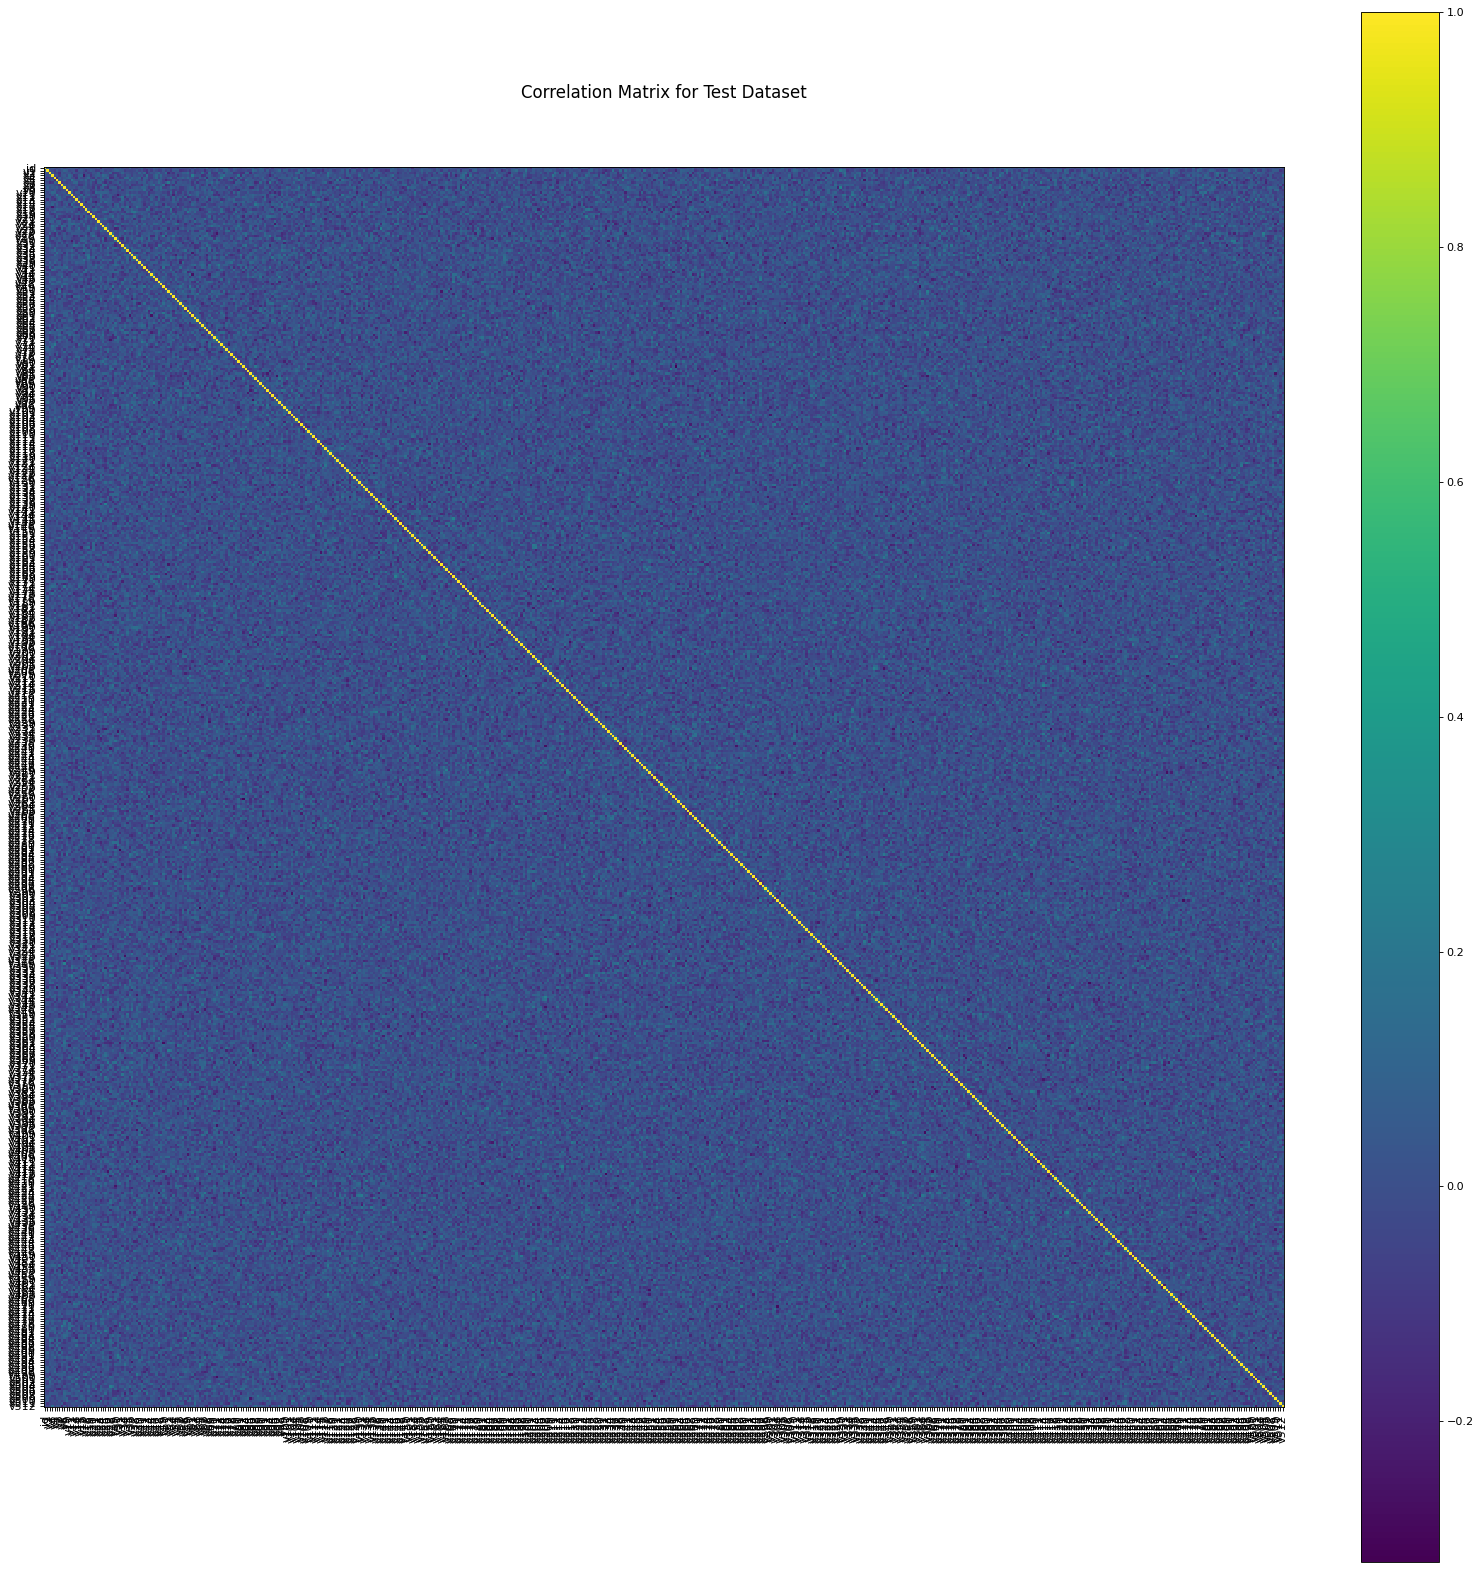

In [19]:
plotCorrelationMatrix(df_test, "Test Dataset", 25)

### Scatter Matrix for Test Dataset

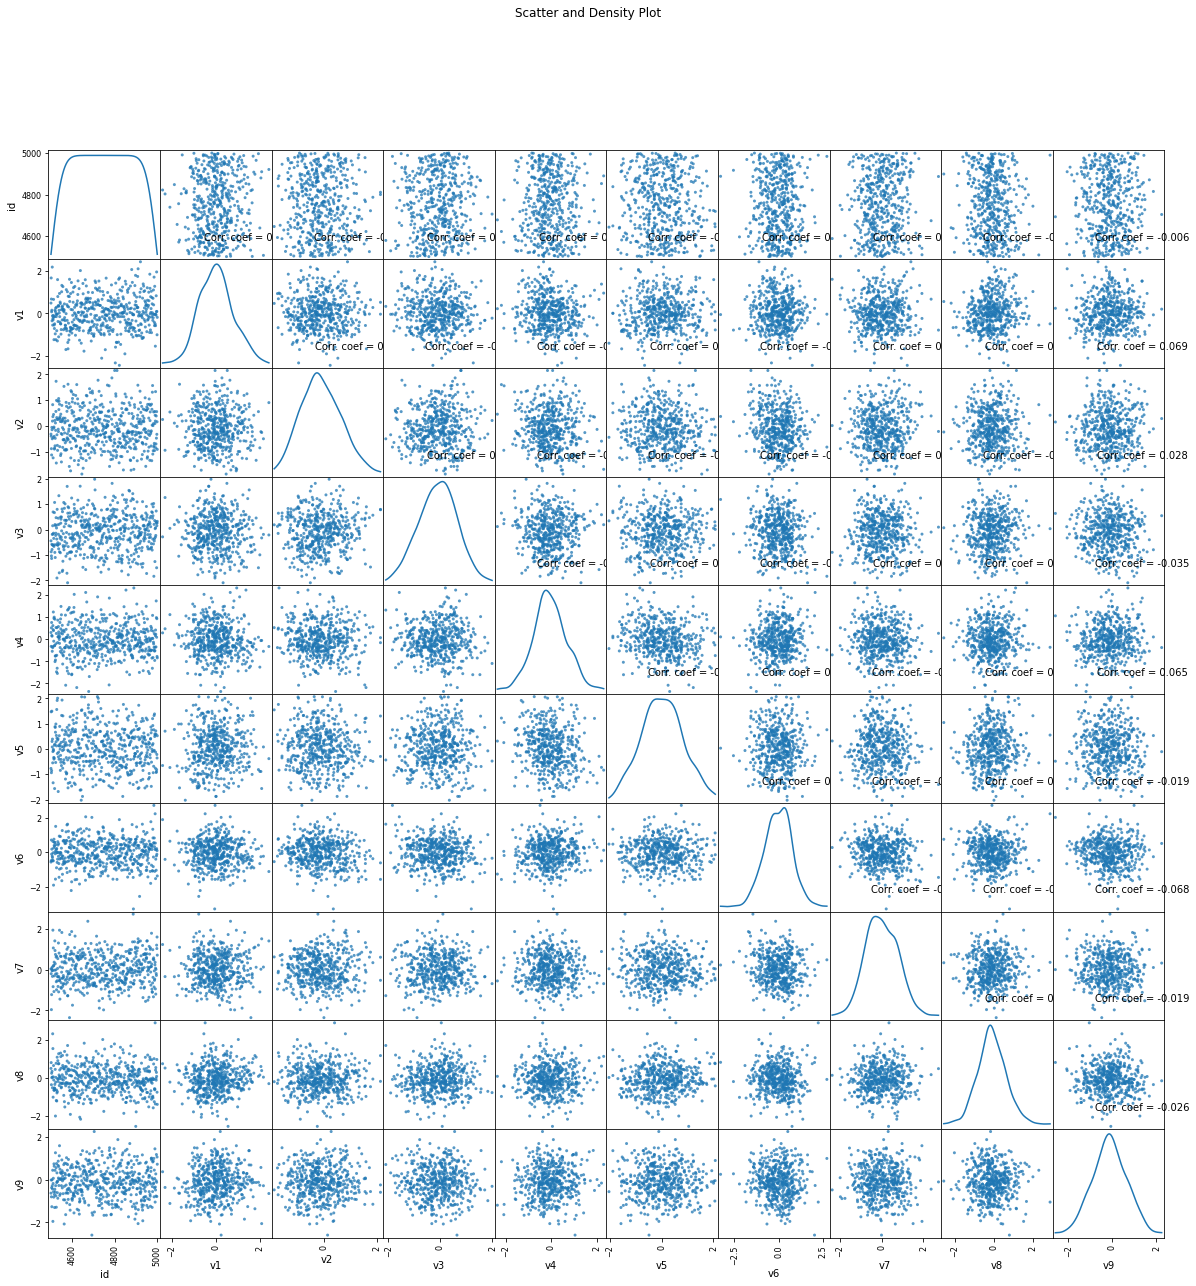

In [20]:
plotScatterMatrix(df_test, 20, 10)

## Model Building

#### MLP Classifier

In [21]:
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

In [22]:
target = ["glasses"]
X = df_train.drop(columns=['glasses', 'id'])
y = df_train[target]
print("X Shape:", X.shape)
print("y Shape:", y.shape)

X Shape: (4500, 512)
y Shape: (4500, 1)


In [23]:
scaler = StandardScaler()
X_cols = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(data=X, columns=X_cols)
X.head()

v1        v2        v3  ...      v510      v511      v512
0  0.452807 -1.181200  0.102604  ...  1.478813  2.160533  0.819784
1  0.060616 -0.033458  0.615916  ...  0.054817 -1.859954 -0.650572
2  1.512846 -0.828903 -0.831967  ... -0.751770  0.460112  0.583441
3  1.714970 -0.326676 -1.660151  ...  1.153261 -0.766916  0.159247
4 -0.083864 -0.363092  0.275191  ...  1.148557  0.679671 -0.166518

[5 rows x 512 columns]

In [24]:
mlp = MLPClassifier(hidden_layer_sizes=(160, 160), activation='relu', solver='adam', max_iter=500)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

In [25]:
scores = cross_val_score(mlp, X, y, scoring="accuracy", cv=skf, n_jobs=-1)

In [26]:
print("The Mean Cross Validation Score for MLP Classifier without Dimensionality Reduction is: {0:.2f}%".format(scores.mean() * 100))

The Mean Cross Validation Score for MLP Classifier without Dimensionality Reduction is: 99.80%


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape);
print(X_test.shape)

(3150, 512)
(1350, 512)


In [28]:
mlp = MLPClassifier(hidden_layer_sizes=(160, 160), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(160, 160), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [29]:
y_pred_test = mlp.predict(X_test)

In [33]:
print("The accuracy of test data for MLP Classifier without Dimensionality Reduction is: {0:.2f}%".format(accuracy_score(y_test, y_pred_test) * 100))

The accuracy of test data for MLP Classifier without Dimensionality Reduction is: 99.78%


## Calculation of Confusion Matrix

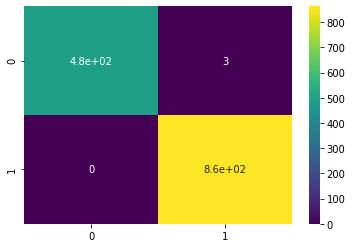

In [34]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, cmap="viridis", annot=True)

In [35]:
print(classification_report(y_test, y_pred_test,  digits=6))

              precision    recall  f1-score   support

           0   1.000000  0.993840  0.996910       487
           1   0.996536  1.000000  0.998265       863

    accuracy                       0.997778      1350
   macro avg   0.998268  0.996920  0.997588      1350
weighted avg   0.997785  0.997778  0.997776      1350



Applying PCA in the code snippet below

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 100)
X_train_pca = pca.fit_transform(X_train, y_train)
X_train_pca = pd.DataFrame(data=X_train_pca)
X_train_pca.head()

0         1         2   ...        97        98        99
0 -2.324144  0.466273  0.388213  ... -1.822521 -1.615280  0.733997
1 -0.269078  0.515134  0.624008  ...  0.955425 -0.091124 -0.599616
2  0.744471 -8.014141 -1.393366  ...  1.706587  0.253680 -0.596544
3  0.291067  0.900684 -0.323231  ... -0.981979 -0.614445  0.322502
4 -0.228336 -3.531947  0.553899  ...  0.789452 -0.605466  0.755143

[5 rows x 100 columns]

In [37]:
mlp_new = MLPClassifier(hidden_layer_sizes=(160, 160), activation='relu', solver='adam', max_iter=500)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
new_scores = cross_val_score(mlp, X_train_pca, y_train, scoring="accuracy", cv=skf, n_jobs=-1)
new_scores.mean()

0.9933333333333334

In [38]:
print("The Mean Cross Validation Score for MLP Classifier with Dimensionality Reduction to 100 dimensions using PCA is: {0:.2f}%".format(new_scores.mean() * 100))

The Mean Cross Validation Score for MLP Classifier with Dimensionality Reduction to 100 dimensions using PCA is: 99.33%


In [39]:
X_test_pca = pca.fit_transform(X_test, y_test)
X_test_pca = pd.DataFrame(data=X_test_pca)
X_test_pca.head()

0         1         2   ...        97        98        99
0 -4.203126  3.044308 -0.956789  ... -0.914729 -0.308759  0.668955
1  0.946115 -0.256992  8.952989  ...  0.673449  0.646219 -1.256971
2  4.571402  2.177100  0.468056  ... -0.129124 -0.016141 -0.675959
3  3.244396  3.523737 -4.475241  ... -0.960910  0.114786  0.513258
4 -0.863199 -2.274620 -0.867171  ... -0.060711  0.177028 -0.275279

[5 rows x 100 columns]

In [40]:
mlp_pca = MLPClassifier(hidden_layer_sizes=(160, 160), activation='relu', solver='adam', max_iter=500)
mlp_pca.fit(X_train_pca, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(160, 160), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [41]:
y_pred_pca = mlp_pca.predict(X_test_pca)
acc_score_pca = accuracy_score(y_test, y_pred_pca)

In [42]:
print("The accuracy of test data for MLP Classifier with data reduced to 250 dimensions using PCA is: {0:.2f}%".format(accuracy_score(y_test, y_pred_pca) * 100))

The accuracy of test data for MLP Classifier with data reduced to 250 dimensions using PCA is: 55.85%


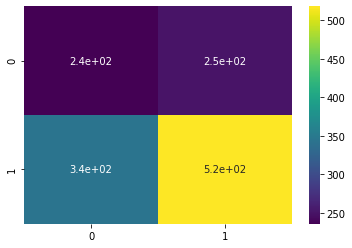

In [43]:
cm = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(cm, cmap="viridis", annot=True)

In [44]:
print(classification_report(y_test, y_pred_pca,  digits=6))

              precision    recall  f1-score   support

           0   0.406196  0.484600  0.441948       487
           1   0.673602  0.600232  0.634804       863

    accuracy                       0.558519      1350
   macro avg   0.539899  0.542416  0.538376      1350
weighted avg   0.577138  0.558519  0.565233      1350



# Classification using Bayes Classifier

### Gaussian Naive Bayes without Dimensionality Reduction

In [45]:
from sklearn.naive_bayes import GaussianNB

In [46]:
gnb = GaussianNB()
mlp = MLPClassifier(hidden_layer_sizes=(160, 160), activation='relu', solver='adam', max_iter=500)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
acc_scores = cross_val_score(mlp, X, y, scoring="accuracy", cv=skf, n_jobs=-1)

In [48]:
print("The accuracy of Cross Validation Score for Naive Bayes Classifier without Dimensionality Reduction is: {0:.2f}%".format(acc_scores.mean() * 100))

The accuracy of Cross Validation Score for Naive Bayes Classifier without Dimensionality Reduction is: 99.76%


In [50]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [51]:
y_pred_test = gnb.predict(X_test)
print("The accuracy of test data for Naive Bayes Classifier without Dimensionality Reduction is: {0:.2f}%".format(accuracy_score(y_test, y_pred_test) * 100))

The accuracy of test data for Naive Bayes Classifier without Dimensionality Reduction is: 98.52%


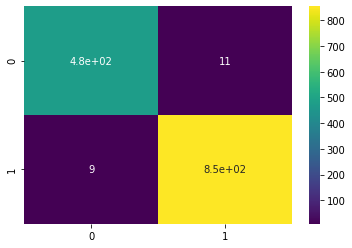

In [52]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, cmap="viridis", annot=True)

In [53]:
print(classification_report(y_test, y_pred_test,  digits=6))

              precision    recall  f1-score   support

           0   0.981443  0.977413  0.979424       487
           1   0.987283  0.989571  0.988426       863

    accuracy                       0.985185      1350
   macro avg   0.984363  0.983492  0.983925      1350
weighted avg   0.985177  0.985185  0.985179      1350



#### Gaussian Naive Bayes with Dimensionality Reduction using PCA

In [54]:
gnb_pca = GaussianNB()
gnb_pca.fit(X_train_pca, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [55]:
y_pred_pca = gnb_pca.predict(X_test_pca)
print("The accuracy of test data for Naive Bayes Classifier with Dimensionality Reduction using PCA is: {0:.2f}%".format(accuracy_score(y_test, y_pred_pca) * 100))

The accuracy of test data for Naive Bayes Classifier with Dimensionality Reduction using PCA is: 97.85%


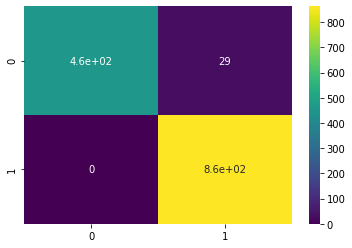

In [56]:
cm = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(cm, cmap="viridis", annot=True)

In [57]:
print(classification_report(y_test, y_pred_pca,  digits=6))

              precision    recall  f1-score   support

           0   1.000000  0.940452  0.969312       487
           1   0.967489  1.000000  0.983476       863

    accuracy                       0.978519      1350
   macro avg   0.983744  0.970226  0.976394      1350
weighted avg   0.979217  0.978519  0.978366      1350



# Classification using Random Forest Classifier

### Random Forest Classifier without Dimensionality Reduction

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
clf = RandomForestClassifier(n_estimators=100)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
acc_scores = cross_val_score(clf, X, y, scoring="accuracy", cv=skf, n_jobs=-1)

In [60]:
print("The accuracy of Cross Validation Score for Random Forest Classifier without Dimensionality Reduction is: {0:.2f}%".format(acc_scores.mean() * 100))

The accuracy of Cross Validation Score for Random Forest Classifier without Dimensionality Reduction is: 97.00%


In [61]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
y_pred_test = clf.predict(X_test)
print("The accuracy of test data for Random Forest Classifier without Dimensionality Reduction is: {0:.2f}%".format(accuracy_score(y_test, y_pred_test) * 100))

The accuracy of test data for Random Forest Classifier without Dimensionality Reduction is: 97.04%


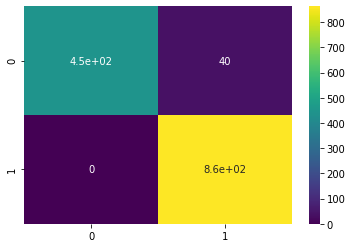

In [63]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, cmap="viridis", annot=True)

In [64]:
print(classification_report(y_test, y_pred_test,  digits=6))

              precision    recall  f1-score   support

           0   1.000000  0.917864  0.957173       487
           1   0.955703  1.000000  0.977350       863

    accuracy                       0.970370      1350
   macro avg   0.977852  0.958932  0.967262      1350
weighted avg   0.971683  0.970370  0.970071      1350



### Random Forest Classifier with Dimensionality Reduction using PCA

In [65]:
clf_pca = RandomForestClassifier(n_estimators=100)
clf_pca.fit(X_train_pca, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [66]:
y_pred_pca = clf_pca.predict(X_test_pca)
print("The accuracy of test data for Random Forest Classifier with Dimensionality Reduction (reduced to 100 components) using PCA is: {0:.2f}%".format(accuracy_score(y_test, y_pred_pca) * 100))

The accuracy of test data for Random Forest Classifier with Dimensionality Reduction (reduced to 100 components) using PCA is: 85.26%


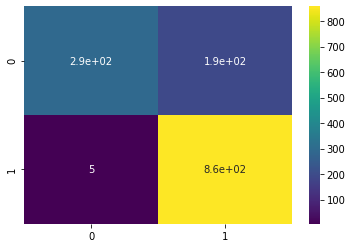

In [67]:
cm = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(cm, cmap="viridis", annot=True)

In [68]:
print(classification_report(y_test, y_pred_test,  digits=6))

              precision    recall  f1-score   support

           0   1.000000  0.917864  0.957173       487
           1   0.955703  1.000000  0.977350       863

    accuracy                       0.970370      1350
   macro avg   0.977852  0.958932  0.967262      1350
weighted avg   0.971683  0.970370  0.970071      1350



## Predictions for Test Set using all three Classifiers

#### Using MLP Classifier

In [74]:
mlp = MLPClassifier(hidden_layer_sizes=(160, 160), activation='relu', solver='adam', max_iter=500)
mlp.fit(X, y)
y_pred_mlp = mlp.predict(df_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [75]:
y_pred_df = pd.DataFrame(y_pred_mlp, columns=['glasses'])
df_final = pd.concat([df_test, y_pred_df], axis=1)
df_final.head()

v1       v2       v3       v4  ...     v510     v511     v512  glasses
0  0.48039 -0.32247 -0.44262  0.29790  ... -0.65184 -0.25504  0.51825        1
1  1.65497 -0.40396 -0.87412 -0.32837  ... -0.44552  0.40221  1.44524        1
2  0.66835 -0.88843 -1.03717  0.50920  ...  1.34367 -0.03853  1.13161        1
3  0.07134 -1.13284 -1.13902  0.74864  ...  0.07702 -0.00753  0.71057        1
4  0.14553 -0.06097 -0.58112  0.16331  ... -1.08812 -0.90550 -0.38300        1

[5 rows x 513 columns]

### Using Naive Bayes or Gaussian Classifier

In [76]:
gnb = GaussianNB()
gnb.fit(X, y)
y_pred_gnb = gnb.predict(df_test)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [77]:
y_pred_df = pd.DataFrame(y_pred_gnb, columns=['glasses'])
df_final = pd.concat([df_test, y_pred_df], axis=1)
df_final.head()

v1       v2       v3       v4  ...     v510     v511     v512  glasses
0  0.48039 -0.32247 -0.44262  0.29790  ... -0.65184 -0.25504  0.51825        1
1  1.65497 -0.40396 -0.87412 -0.32837  ... -0.44552  0.40221  1.44524        1
2  0.66835 -0.88843 -1.03717  0.50920  ...  1.34367 -0.03853  1.13161        1
3  0.07134 -1.13284 -1.13902  0.74864  ...  0.07702 -0.00753  0.71057        1
4  0.14553 -0.06097 -0.58112  0.16331  ... -1.08812 -0.90550 -0.38300        1

[5 rows x 513 columns]

### Using Random Forest Classifier

In [78]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)
y_pred_clf = clf.predict(df_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [79]:
y_pred_df = pd.DataFrame(y_pred_clf, columns=['glasses'])
df_final = pd.concat([df_test, y_pred_df], axis=1)
df_final.head()

v1       v2       v3       v4  ...     v510     v511     v512  glasses
0  0.48039 -0.32247 -0.44262  0.29790  ... -0.65184 -0.25504  0.51825        1
1  1.65497 -0.40396 -0.87412 -0.32837  ... -0.44552  0.40221  1.44524        1
2  0.66835 -0.88843 -1.03717  0.50920  ...  1.34367 -0.03853  1.13161        1
3  0.07134 -1.13284 -1.13902  0.74864  ...  0.07702 -0.00753  0.71057        1
4  0.14553 -0.06097 -0.58112  0.16331  ... -1.08812 -0.90550 -0.38300        1

[5 rows x 513 columns]

# Submitted By :-
- Harish Kumar (B19CSE035)
- Harsh Kumar (B19CSE036)
- Himanshu Raj (B19EE038)

# Thank You